# 1. Install neccesarry libraries

In [156]:
 # This is a library for image reshaping
!pip install Pillow 

#Import neccesary libraries
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from PIL import Image

# 2. Read the csv files and exploration

We will have 2 different csv files. 

First one *'GroundTruth.csv '* contains images_id with their labes.

And the other one *'HAM10000_metadata.csv'* is contains a informations regading the image itself.



## 2.1 Reading CSV files and concatanate 

In [146]:
#Read the csv files into a dataframe

df = pd.read_csv('GroundTruth.csv')

df2 = pd.read_csv('HAM10000_metadata.csv')

df.head(5)

#!ls "./images/images" #Before preprocessing checked directory 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   10015 non-null  object 
 1   MEL     10015 non-null  float64
 2   NV      10015 non-null  float64
 3   BCC     10015 non-null  float64
 4   AKIEC   10015 non-null  float64
 5   BKL     10015 non-null  float64
 6   DF      10015 non-null  float64
 7   VASC    10015 non-null  float64
dtypes: float64(7), object(1)
memory usage: 626.1+ KB


In [147]:
df2.head(5)

df2.info()

#As we can see in df2 the column with image_id is different than the one in df.
#We need to change the column name in df2 to match the one in df

df2 = df2.rename(columns={'image_id': 'image'},inplace=False)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


### 2.1.1 Data Cleaning  

 We can see from previous cell, there is non-null values from age

Lets check it 

In [148]:
df2.isnull().sum()


lesion_id        0
image            0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [150]:
#Since we see age column has some non values we need to adjust them with mean value

df2['age'].fillna((df2['age'].mean()), inplace=True)

df2.isnull().sum()

lesion_id       0
image           0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

## 2.2 Dataframe Concatenation

In order to make a analysis based on the images we can concatenate both dataframes to one 

In [72]:
#Merge the two dataframes on the image_id column

df3 = pd.merge(df, df2, on='image')

df3.head(5)

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC    lesion_id   dx  \
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0000550   nv   
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0003577   nv   
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0001477   nv   
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0  HAM_0000484   nv   
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0  HAM_0003350  mel   

     dx_type   age     sex     localization  
0  follow_up  45.0    male            trunk  
1  follow_up  50.0    male  lower extremity  
2  follow_up  55.0  female            trunk  
3  follow_up  40.0    male            trunk  
4      histo  60.0    male            chest

In [31]:
#Show the number of columns we have to proccess
print(len(df))

#Show the columns we have to proccess
print(df.columns)

#drop the image column from the dataframe so that create a label array

labels = df.drop(columns=['image'])

10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [33]:
#From above we can see that our dataframe is not contain .jpg extension so we have to add it to the dataframe
#This will help us to read the images from the directory

df['image'] = df['image'].apply(lambda x: x + '.jpg')

print(df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


# 3. Data preprocessing

## 3.1 Resizing the images

Resizing images will be helpful for us to work on models.

This images are formed as RGB which is Red,Green and Blue Channels.

When re-size the images as (128,128) it will create a a column as 128x128x3 = 49152 as showed in resized_images[0]

In [167]:
import os
from IPython.display import Image, display

from PIL import Image

image_directory = './images/images' 

#We need to end of the file as jnp because in the directory there is .txt file
image_files = [os.path.join(image_directory, file) for file in os.listdir(image_directory) if file.endswith('.jpg')]

#Sort the images based on their indexis
image_files.sort()

count = 0

#Resize the images to 128x128
resized_images = []
for image_file in image_files:
    
    with Image.open(image_file) as img:
    
        img = img.resize((128,128))
        #Make sure that the image is RGB and convert it to numpy array
        img_array = np.array(img)

        #Normalize the image
        img = img_array/ 255.0


        #print(img.size)
        resized_images.append(img_array)


#This shows the shape of my images and the min and max values of the pixels
#This will help us to see if there is any problem with the images
img_array.shape, img_array.min(), img_array.max()

((128, 128, 3), 15, 239)

In [168]:
#This convertion is neccesarry since we are feeding the images to the neural network as numpy array 
# numpy make it as 4 dimensional array, before proccesing we had 3 dimensional array
X = np.array(resized_images)

X.shape

(10015, 128, 128, 3)

 Display each cancer type images for 5 times to see how they look like

In [179]:
from collections import defaultdict

cancer_images = defaultdict(list)

#we will take 5 different images for each cancer type
#In order to do it we need to create a dictionary with contain cancer types and corresponding images
num_images = 5

#Iterate over the dataframe and append the images to the dictionary
for i, r in df3.iterrows():
    c_type = r['dx'] #cancer type
    image_f = r['image'] # image file name
    image_f =image_f +'.jpg'

    if len(cancer_images[c_type]) < num_images: # Control the number of images
        cancer_images[c_type].append(image_f)

cancer_images.values()
cancer_images[0]


[]

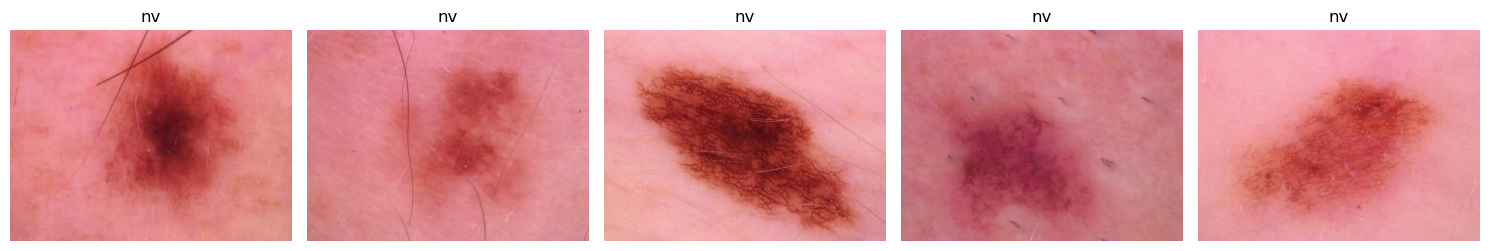

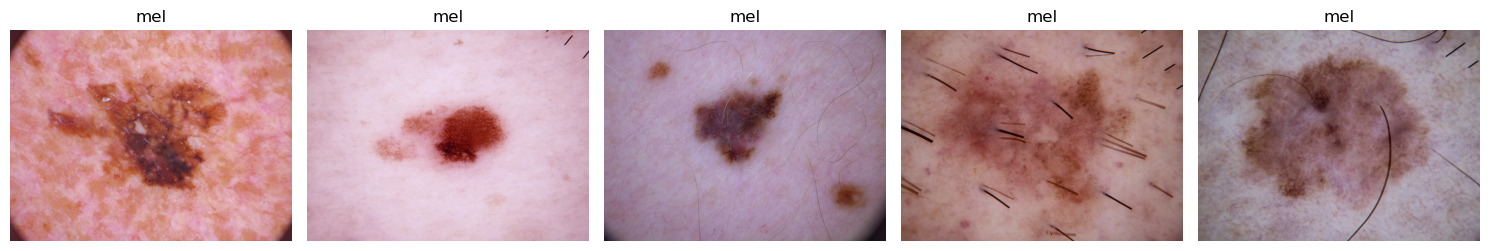

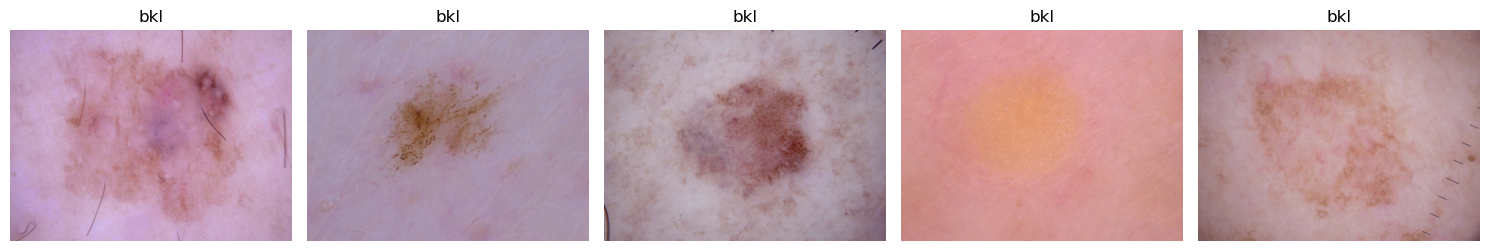

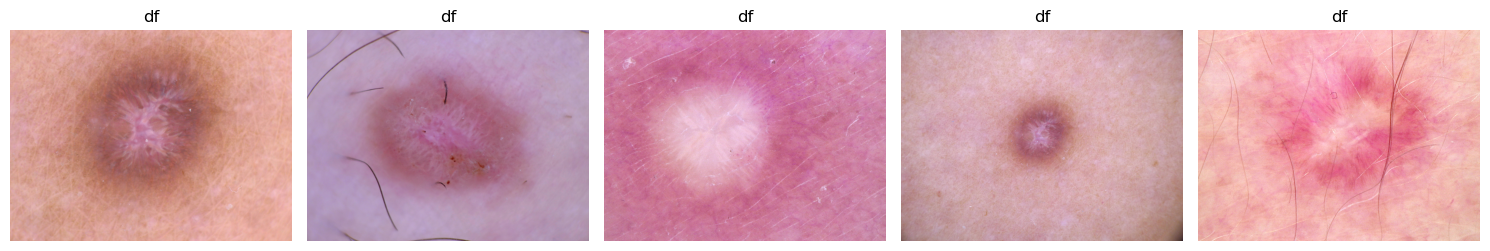

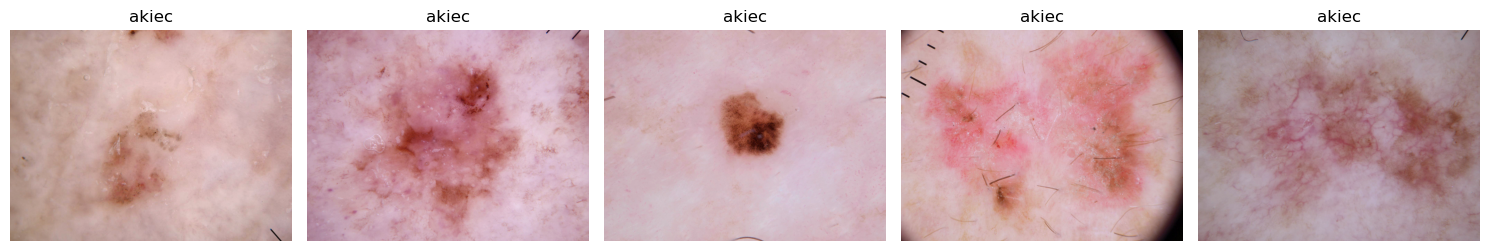

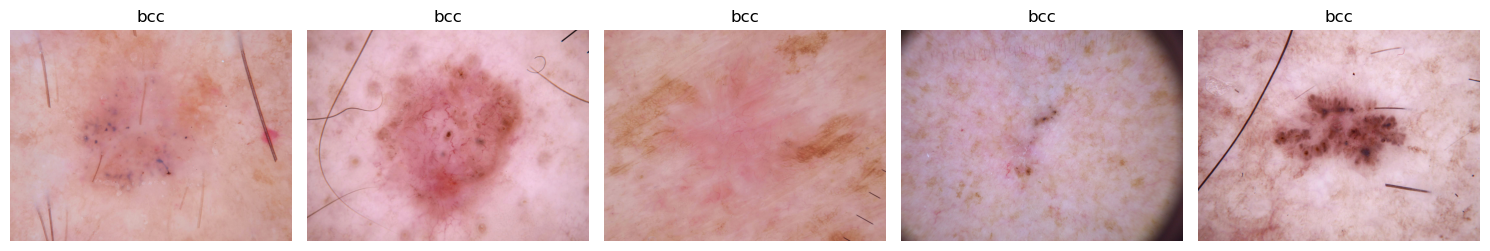

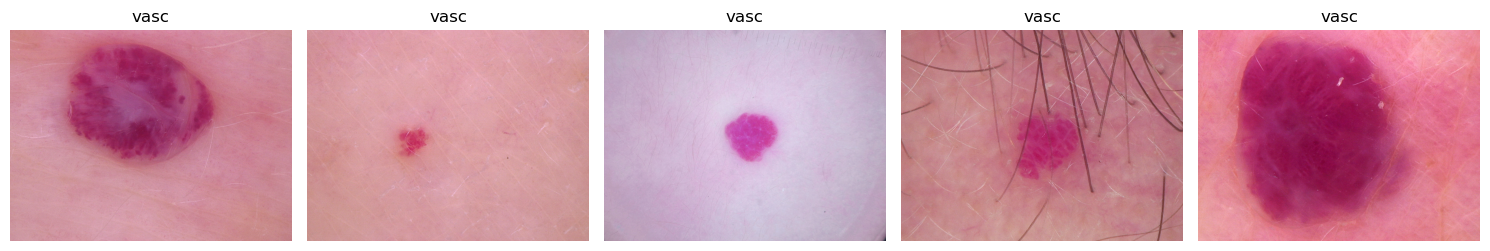

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1500x500 with 0 Axes>

In [184]:
def display_cancer_types(images_dict,image_directory):
    for cancer_type in images_dict.keys():
        # Get image filenames
        image_files = images_dict[cancer_type][:5]

        # Set up the matplotlib figure
        fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))

        # Display each image
        for ax, file_path in zip(axes, image_files):
            #Construct the full file path
            file_path = os.path.join(image_directory, file_path)


            #print(f"Trying to open: {file_path}")  # Print the file path
            try:
                with Image.open(file_path) as img:
                    ax.imshow(img)
                    ax.axis('off')  # Hide the axis
                ax.set_title(cancer_type)
            except FileNotFoundError:
                print(f"File not found: {file_path}")

        plt.tight_layout()
        plt.show()

# Call the function
display_cancer_types(cancer_images, image_directory)


    


## 3.2 Preprocessing the One-hot encoding Y labels

In [111]:
#One hot encoding for the labels expect the image column from first dataframe
y = pd.get_dummies(df.drop(columns=['image']))

#print(y.values)
#Create a one hot encoded array for  Numpy Array    
y = np.array(y)

y

#For reecomendation, we can check the distribution of the y values between the classes

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# 4. Splitting the data

In [119]:
!pip install keras 
!pip install tensorflow -- quiet


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [118]:
#Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

#Check the shape of the train and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Import the neccesary libraries for the model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

#Create a model

model = Sequential()

#Add the layers to the model
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))



(8512, 128, 128, 3)
(1503, 128, 128, 3)
(8512, 7)
(1503, 7)
